evaluation strukturiert

In [1]:
# es wurde auf der cpu predicted weil die GPU mit dem training des großen modell beschäftigt war
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import numpy  as np
import cv2
import numpy as np
from matplotlib import pyplot as plt
import rasterio
from rasterio import plot
from osgeo import gdal
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow import keras
import tensorflow.keras.backend as K

In [4]:
raster = np.load('Test_Raster.npy')
mask = np.load('Test_Mask.npy')

In [5]:
#raster = raster/255
np.max(raster)

1.0

In [5]:

def create_256_arrays_raster(raster):
    i = 0
    j = 0
    i_pixel = 0
    länge = raster.shape[1]
    bilder = []
    overlap = 256
    patches = raster.shape[0]
    for l in range(0,patches):
        i=0
        i_pixel=0
        while ((i_pixel+256) <= länge):
            j = 0
            j_pixel = 0
            höhe = raster.shape[2]
            while ((j_pixel+256) <= höhe):
                bild = raster[l,i_pixel:(i_pixel)+256, j_pixel:(j_pixel)+256,:]
                bild = bild.reshape(256,256,3)

                bilder.append(bild)
                j = j+1
                j_pixel = j*overlap
            i = i+1
            i_pixel = i*overlap
    bilder = np.array(bilder)
    return bilder

In [30]:
# pred = create_256_arrays_raster(raster)
# pred.shape

patch 0 done!
patch 1 done!
patch 2 done!
patch 3 done!
patch 4 done!
patch 5 done!
patch 6 done!
patch 7 done!
patch 8 done!


(14400, 256, 256, 3)

In [6]:
def prediction(model, raster):

    segm_img = np.zeros((9,10240,10240,1),dtype=float)
    patches = create_256_arrays_raster(raster)
    patches = patches/255
    predictions = model.predict(patches)
    
    k = 0
    for l in range(0,9):
        for i in range(0, 40):   
            for j in range(0, 40):  
                segm_img[l, (i*256):((i+1)*256), (j*256):((j+1)*256), :] += predictions[k].reshape(256,256,1)
                k+=1

    return segm_img

In [7]:
model = keras.models.load_model('model/UNet_big_IoULoss_Oversampling_Vers.1_', compile = False)

In [8]:
def make_256_tiles(raster,mask):
    i = 0
    j = 0
    i_pixel = 0
    länge = raster.shape[1]
    bilder = []
    mbilder = []
    overlap = 256
    patches = raster.shape[0]
    for l in range(0,patches):
        i=0
        i_pixel=0
        while ((i_pixel+256) <= länge):
            j = 0
            j_pixel = 0
            höhe = raster.shape[2]
            while ((j_pixel+256) <= höhe):
                bild = raster[l,i_pixel:(i_pixel)+256, j_pixel:(j_pixel)+256,:]
                mbild = mask[l,i_pixel:(i_pixel)+256, j_pixel:(j_pixel)+256,:]
                bild = bild.reshape(256,256,3)
                mbild = mbild.reshape(256,256,1)


                bilder.append(bild)
                mbilder.append(mbild)
                j = j+1
                j_pixel = j*overlap
            i = i+1
            i_pixel = i*overlap
    bilder = np.array(bilder)
    return bilder, mbilder

In [8]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

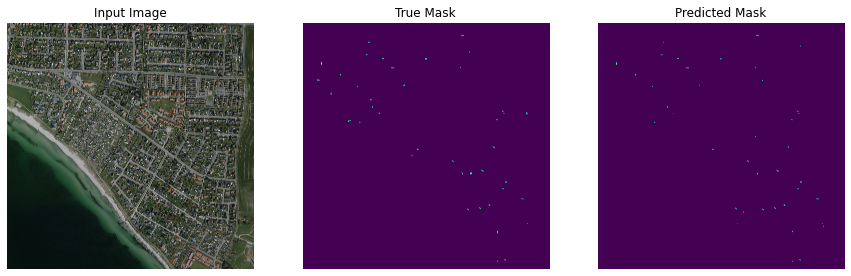

In [10]:
index = 8
display([raster[index],mask[index],y_pred[index]])

In [23]:
def precision(tp, fp):
    presision = tp /(tp+fp)
    return presision

In [24]:
def recall(tp, fn):
    recall = tp/(tp+fn)   
    return recall

In [10]:
def F1_Score(precision, recall):
    F1 = 2*((precision*recall)/(precision+recall))
    return F1

In [11]:
def IoU(tp,fp,fn):
    IoU = tp/(tp+fp+fn)
    return IoU

In [12]:
def accuracy(tp,tn,fp,fn):
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    return accuracy

In [13]:
def get_confusion_matrix_intersection_mats(groundtruth, predicted):
    """ Returns dict of 4 boolean numpy arrays with True at TP, FP, FN, TN
    """

    groundtruth_inverse = np.logical_not(groundtruth)
    predicted_inverse = np.logical_not(predicted)

    tp = np.sum(np.logical_and(groundtruth, predicted))
    tn = np.sum(np.logical_and(groundtruth_inverse, predicted_inverse))
    fp = np.sum(np.logical_and(groundtruth_inverse, predicted))
    fn = np.sum(np.logical_and(groundtruth, predicted_inverse))

    return [tp, tn, fp, fn]
# https://www.kite.com/blog/python/image-segmentation-tutorial/

In [18]:
# model_path_list = ['checkpoint/UNet_small_BCE_Oversampling_Vers.8_', 'checkpoint/UNet_small_DiceLoss_Oversampling_Vers.7_']
model_path_list = ['checkpoint/UNet_small_BCE_Oversampling_Vers.8_', 'checkpoint/UNet_small_DiceLoss_Oversampling_Vers.7_','checkpoint/UNet_small_IoULoss_Oversampling_Vers.6_','checkpoint/UNet_small_TverskyLoss_07_03_Oversampling_Vers.6_' ]
# threshs = [0.5,0.8]
threshs = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

In [14]:
def get_confuison_matrixs_by_thresh(y, pred, threshs):
    confs = []
    for i in threshs:
        pred1 = np.where(pred > i, 1, 0)
        conf = get_confusion_matrix_intersection_mats(y,pred1)
        confs.append(conf)
        print(str(i) + ' confusion done!')
    return confs

In [15]:
def dertermine_threshold_values(conf_values):
    precisions = []
    recalls    = []
    F1scores   = []
    IoUs       = []
    conf_values = []
    accuracys = []
    i = 0.3
    for i in range(0,len(conf_values)):

        tp = conf_value[i][0]
        tn = conf_value[i][1]
        fp = conf_value[i][2]
        fn = conf_value[i][3]
        
        preci = precision(tp,fp)
        precisions.append(preci)
        rec = recall(tp,fn)
        recalls.append(rec)
        F1 = F1_Score(preci, rec)
        F1scores.append(F1)
        Jaccard = IoU(tp,fp,fn)
        IoUs.append(Jaccard)
        acc = accuracy(tp,tn,fp,fn)
        accuracys.append(acc)
        print('threshold: ' + str(i) + ' done!')
    return [precisions, recalls, F1scores, IoUs, accuracys]

In [42]:
def go_through_all_models(raster,mask,threshs,model_path_list):
    metrics = []
    confs = []
    mask = mask.flatten()
    model = keras.models.load_model('model/UNet_small_DiceLoss_Oversampling_Vers.6_', compile=False)
    for weights_path in model_path_list:
        model.load_weights(weights_path)
        print ( 'model: ' + weights_path + ' loaded')
        pred = prediction(model, raster)
        pred = pred.flatten()
        print ('raster predicted')
        conf = get_confuison_matrixs_by_thresh(mask,pred,threshs)
        confs.append(conf)
        print ('got confusion matrix values for: ' + weights_path)
        metric = get_metrics_by_confs(conf)
        metrics.append(metric)
        print ('got metric values')
    return confs, metrics

In [17]:
def get_metrics_by_confs(conf):
    precisions = []
    recalls    = []
    F1scores   = []
    IoUs       = []
    conf_values = []
    accuracys = []
    i = 0.3
    for i in range(0,len(conf)):
        
        tp = conf[i][0]
        tn = conf[i][1]
        fp = conf[i][2]
        fn = conf[i][3]
        
        preci = precision(tp,fp)
        precisions.append(preci)
        rec = recall(tp,fn)
        recalls.append(rec)
        F1 = F1_Score(preci, rec)
        F1scores.append(F1)
        Jaccard = IoU(tp,fp,fn)
        IoUs.append(Jaccard)
        acc = accuracy(tp,tn,fp,fn)
        accuracys.append(acc)
    return [precisions, recalls, F1scores, IoUs, accuracys]

In [45]:
confs, metrics = go_through_all_models(raster,mask,threshs,model_path_list)

model: checkpoint/UNet_small_BCE_Oversampling_Vers.8_ loaded
raster predicted
0.1 confusion done!
0.2 confusion done!
0.3 confusion done!
0.4 confusion done!
0.5 confusion done!
0.6 confusion done!
0.7 confusion done!
0.8 confusion done!
0.9 confusion done!
got confusion matrix values for: checkpoint/UNet_small_BCE_Oversampling_Vers.8_
got metric values
model: checkpoint/UNet_small_DiceLoss_Oversampling_Vers.7_ loaded
raster predicted
0.1 confusion done!
0.2 confusion done!
0.3 confusion done!
0.4 confusion done!
0.5 confusion done!
0.6 confusion done!
0.7 confusion done!
0.8 confusion done!
0.9 confusion done!
got confusion matrix values for: checkpoint/UNet_small_DiceLoss_Oversampling_Vers.7_
got metric values
model: checkpoint/UNet_small_IoULoss_Oversampling_Vers.6_ loaded
raster predicted
0.1 confusion done!
0.2 confusion done!
0.3 confusion done!
0.4 confusion done!
0.5 confusion done!
0.6 confusion done!
0.7 confusion done!
0.8 confusion done!
0.9 confusion done!
got confusion ma

In [29]:
confsarr = np.asarray(confs)
metricsarr = np.asarray(metrics)
np.save('confs.npy', confsarr)
np.save('metrics.npy', metricsarr)

In [20]:
def get_mean_IoU_values(raster,mask,threshs,model_path_list):
    mIoUs = []
    model = keras.models.load_model('model/UNet_small_DiceLoss_Oversampling_Vers.6_', compile=False)
    
    for weights_path in model_path_list:
        model.load_weights(weights_path)
        print ( 'model: ' + weights_path + ' loaded')
        pred = prediction(model, raster)
#         pred = pred.flatten()
        print ('raster predicted')
        for i in threshs:
            pred1 = np.where(pred > i, 1, 0)
            m = tf.keras.metrics.MeanIoU(num_classes=2)
            m.update_state(mask, pred1)
            mIoU = m.result().numpy()
            mIoUs.append(mIoU)
            #m.reset_state()
            print (str(i) + ': ' + str(mIoU))
    return mIoUs

In [9]:
mIoUs2 = get_mean_IoU_values(raster,mask,threshs,model_path_list)
mIoUs2 = np.asarray(mIoUs2)
np.save('mIoUs2.npy', mIoUs2)

model: checkpoint/UNet_small_BCE_Oversampling_Vers.8_ loaded
raster predicted
0.1: 0.7025392
0.2: 0.70104635
0.3: 0.69861054
0.4: 0.6955762
0.5: 0.6920155
0.6: 0.68838966
0.7: 0.6841068
0.8: 0.67816985
0.9: 0.66864693
model: checkpoint/UNet_small_DiceLoss_Oversampling_Vers.7_ loaded
raster predicted
0.1: 0.6849053
0.2: 0.6849052
0.3: 0.6849064
0.4: 0.6848948
0.5: 0.68487203
0.6: 0.68487847
0.7: 0.68487054
0.8: 0.6848404
0.9: 0.6847983
model: checkpoint/UNet_small_IoULoss_Oversampling_Vers.6_ loaded
raster predicted
0.1: 0.7161425
0.2: 0.7160632
0.3: 0.7160269
0.4: 0.7159772
0.5: 0.7159233
0.6: 0.7158586
0.7: 0.71580046
0.8: 0.7157398
0.9: 0.7156272
model: checkpoint/UNet_small_TverskyLoss_07_03_Oversampling_Vers.6_ loaded
raster predicted
0.1: 0.6905161
0.2: 0.6904969
0.3: 0.69048417
0.4: 0.6904851
0.5: 0.6904923
0.6: 0.69044375
0.7: 0.6903876
0.8: 0.69038033
0.9: 0.6903198


In [46]:
mIoUs2 = np.load('mIoUs2.npy')

In [19]:
def determine_bests(metrics, models, threshs, mIoUs):
    BOLD = '\033[1m'
    END = '\033[0m'
    l = 0
    for j in range(0,len(models)):
        print(models[j])
        maxprecision = max(metrics[j][0])
        maxrecall = max(metrics[j][1])
        maxF1 = max(metrics[j][2])
        maxIoU = max(metrics[j][3])
        maxacc = max(metrics[j][4])
        maxmIoU = np.max(mIoUs)
        threshs = threshs


        for i in range(0,len(metrics[j][0])):
                
            if(maxacc == metrics[j][4][i]):
                stracc = BOLD + ',Accuracy: ' + str(metrics[j][4][i]) + END
            else:
                stracc = ',Accuracy: ' + str(metrics[j][4][i])    
#             if(maxrecall == metrics[j][1][i]):
#                 strrecall = BOLD + ',Rec: ' + str(metrics[j][1][i]) + END
#             else:
#                 strrecall = ',Rec: ' + str(metrics[j][1][i])    
                
            if(maxF1 == metrics[j][2][i]):
                strF1 = BOLD + ',F1: ' + str(metrics[j][2][i]) + END
            else:
                strF1 = ',F1: ' + str(metrics[j][2][i])
            if(maxIoU == metrics[j][3][i]):
                strIoU = BOLD + ',IoU: ' + str(metrics[j][3][i]) + END
            else: 
                strIoU = ',IoU: ' + str(metrics[j][3][i])
            if(maxmIoU == mIoUs[l]):
                strmIoU = BOLD + ',meanIoU: ' + str(mIoUs[l]) + END
            else: 
                strmIoU = ',meanIoU: ' + str(mIoUs[l])

#             print('Threshold: ' + str(threshs[i])  + strF1 + strIoU)
            print('T: ' + str(threshs[i]) + stracc + strF1 + strIoU, strmIoU)
            l += 1
    return maxprecision,maxrecall , maxF1, maxIoU

In [48]:
maxprecision,maxrecall, mF1,mIoU = determine_bests(metrics, model_path_list, threshs,mIoUs2)

checkpoint/UNet_small_BCE_Oversampling_Vers.8_
T: 0.1,Accuracy: 0.9997834142049153,F1: 0.5768111141017412,IoU: 0.40529484161737367 ,meanIoU: 0.7025392
T: 0.2,Accuracy: 0.9997890800899929,F1: 0.5737754413764307,IoU: 0.40230371711602964 ,meanIoU: 0.70104635
T: 0.3,Accuracy: 0.9997913106282552,F1: 0.5688012330974568,IoU: 0.3974299351364582 ,meanIoU: 0.69861054
T: 0.4,Accuracy: 0.9997922113206652,F1: 0.5625577213936119,IoU: 0.39136021652223574 ,meanIoU: 0.6955762
T: 0.5,Accuracy: 0.9997922960917155,F1: 0.5551626944322149,IoU: 0.38423889824332136 ,meanIoU: 0.6920155
T: 0.6,Accuracy: 0.9997922028435601,F1: 0.5475536769829221,IoU: 0.3769872031109021 ,meanIoU: 0.68838966
T: 0.7,Accuracy: 0.9997916730244955,F1: 0.5384626219563727,IoU: 0.3684220670956384 ,meanIoU: 0.6841068
T: 0.8,Accuracy: 0.9997902679443359,F1: 0.5256710122699386,IoU: 0.3565493296576117 ,meanIoU: 0.67816985
T: 0.9,Accuracy: 0.9997872045305041,F1: 0.5046801814356503,IoU: 0.33750651544242327 ,meanIoU: 0.66864693
checkpoint/UNet_

In [21]:
def get_confs(confs,threshs,model_path_list):
    
    for j in range(0,len(confs)):
        conf = confs[j]
        print (model_path_list[j])
        for i in range(0, len(threshs)):
            tp = conf[i][0]
            tn = conf[i][1]
            fp = conf[i][2]
            fn = conf[i][3]

            print ('Threshold ' + str(threshs[i]) + ':' +' tp: ' + str(tp) + ', tn: ' + str(tn) + ', fp: ' + str(fp) + ', fn: ' + str(fn))

In [47]:
get_confs(confs,threshs,model_path_list)

checkpoint/UNet_small_BCE_Oversampling_Vers.8_
Threshold 0.1: tp: 139297, tn: 943374707, fp: 69651, fn: 134745
Threshold 0.2: tp: 133978, tn: 943385373, fp: 58985, fn: 140064
Threshold 0.3: tp: 129896, tn: 943391560, fp: 52798, fn: 144146
Threshold 0.4: tp: 126090, tn: 943396216, fp: 48142, fn: 147952
Threshold 0.5: tp: 122314, tn: 943400072, fp: 44286, fn: 151728
Threshold 0.6: tp: 118662, tn: 943403636, fp: 40722, fn: 155380
Threshold 0.7: tp: 114685, tn: 943407113, fp: 37245, fn: 159357
Threshold 0.8: tp: 109676, tn: 943410796, fp: 33562, fn: 164366
Threshold 0.9: tp: 102307, tn: 943415274, fp: 29084, fn: 171735
checkpoint/UNet_small_DiceLoss_Oversampling_Vers.7_
Threshold 0.1: tp: 129524, tn: 943368377, fp: 75981, fn: 144518
Threshold 0.2: tp: 129401, tn: 943368709, fp: 75649, fn: 144641
Threshold 0.3: tp: 129330, tn: 943368903, fp: 75455, fn: 144712
Threshold 0.4: tp: 129266, tn: 943369054, fp: 75304, fn: 144776
Threshold 0.5: tp: 129196, tn: 943369200, fp: 75158, fn: 144846
Thres

In [26]:
def go_through_big_model(raster,mask,threshs):
    metrics = []
    confs = []
    mask = mask.flatten()
    model = keras.models.load_model('model/UNet_big_IoULoss_Oversampling_Vers.1_', compile=False)
    pred = prediction(model, raster)
    pred = pred.flatten()
    print ('raster predicted')
    conf = get_confuison_matrixs_by_thresh(mask,pred,threshs)
    confs.append(conf)
    #print ('got confusion matrix values for: ' + weights_path)
    metric = get_metrics_by_confs(conf)
    metrics.append(metric)
    print ('got metric values')
    return confs, metrics

In [23]:
def get_big_mean_IoU_values(raster,mask,threshs):
    mIoUs = []
    model = keras.models.load_model('model/UNet_big_IoULoss_Oversampling_Vers.1_', compile=False)
    pred = prediction(model, raster)
#         pred = pred.flatten()
    print ('raster predicted')
    for i in threshs:
        pred1 = np.where(pred > i, 1, 0)
        m = tf.keras.metrics.MeanIoU(num_classes=2)
        m.update_state(mask, pred1)
        mIoU = m.result().numpy()
        mIoUs.append(mIoU)
        #m.reset_state()
        print (str(i) + ': ' + str(mIoU))
    return mIoUs

In [24]:
mIoUs_big = get_big_mean_IoU_values(raster,mask,threshs)
mIoUs_big = np.asarray(mIoUs_big)
np.save('mIoUs_big.npy', mIoUs_big)

raster predicted
0.1: 0.7506223
0.2: 0.7505301
0.3: 0.75048196
0.4: 0.75043786
0.5: 0.7503987
0.6: 0.750371
0.7: 0.7503514
0.8: 0.7502959
0.9: 0.7502166


In [27]:
confs_big, metrics_big = go_through_big_model(raster,mask,threshs)

confsarr_big = np.asarray(confs_big)
metricsarr_big = np.asarray(metrics_big)
np.save('confs.npy', confsarr_big)
np.save('metrics.npy', metricsarr_big)

raster predicted
0.1 confusion done!
0.2 confusion done!
0.3 confusion done!
0.4 confusion done!
0.5 confusion done!
0.6 confusion done!
0.7 confusion done!
0.8 confusion done!
0.9 confusion done!
got metric values


In [28]:
model_path_list = ['model/UNet_big_IoULoss_Oversampling_Vers.1_']

In [30]:
maxprecision,maxrecall, mF1,mIoU = determine_bests(metrics_big, model_path_list, threshs,mIoUs_big)

model/UNet_big_IoULoss_Oversampling_Vers.1_
T: 0.1,Accuracy: 0.99983826107449,F1: 0.6679154972477863,IoU: 0.5014062515311972 ,meanIoU: 0.7506223
T: 0.2,Accuracy: 0.9998382345835368,F1: 0.6677519538433748,IoU: 0.501221942692848 ,meanIoU: 0.7505301
T: 0.3,Accuracy: 0.9998382261064318,F1: 0.6676665541974597,IoU: 0.5011257176654348 ,meanIoU: 0.75048196
T: 0.4,Accuracy: 0.9998382080925835,F1: 0.6675883029120803,IoU: 0.5010375579643603 ,meanIoU: 0.75043786
T: 0.5,Accuracy: 0.9998381974962023,F1: 0.6675187583557969,IoU: 0.5009592161553571 ,meanIoU: 0.7503987
T: 0.6,Accuracy: 0.9998381964365641,F1: 0.6674695174402272,IoU: 0.5009037513033303 ,meanIoU: 0.750371
T: 0.7,Accuracy: 0.999838203854031,F1: 0.6674347894269137,IoU: 0.500864636215345 ,meanIoU: 0.7503514
T: 0.8,Accuracy: 0.9998381816016303,F1: 0.667336157976713,IoU: 0.5007535560982467 ,meanIoU: 0.7502959
T: 0.9,Accuracy: 0.9998381582895914,F1: 0.6671954363112216,IoU: 0.5005951018539712 ,meanIoU: 0.7502166


In [31]:
get_confs(confs_big,threshs,model_path_list)

model/UNet_big_IoULoss_Oversampling_Vers.1_
Threshold 0.1: tp: 153497, tn: 943412267, fp: 32091, fn: 120545
Threshold 0.2: tp: 153409, tn: 943412330, fp: 32028, fn: 120633
Threshold 0.3: tp: 153358, tn: 943412373, fp: 31985, fn: 120684
Threshold 0.4: tp: 153321, tn: 943412393, fp: 31965, fn: 120721
Threshold 0.5: tp: 153283, tn: 943412421, fp: 31937, fn: 120759
Threshold 0.6: tp: 153250, tn: 943412453, fp: 31905, fn: 120792
Threshold 0.7: tp: 153219, tn: 943412491, fp: 31867, fn: 120823
Threshold 0.8: tp: 153172, tn: 943412517, fp: 31841, fn: 120870
Threshold 0.9: tp: 153097, tn: 943412570, fp: 31788, fn: 120945


In [26]:
print (str(precision(153497, 32091)) + ' : ' + str(precision(153097, 31788)))
print (str(recall(153497, 120545)) +' : ' +str(recall(153097, 120945)))        

0.8270847253055155 : 0.8280660951402223
0.560122171054072 : 0.5586625407784208
